This notebook is to use the SAM pipeline using RGB only

In [1]:
import rosbag
import cv_bridge
from tqdm import tqdm
import cv2
from PIL import Image
import numpy as np
import csv
import os
import json


from torch.utils.data import DataLoader, Dataset

from pathlib import Path

import params.robot
import params.dataset
from params import PROJECT_PATH

import matplotlib.pyplot as plt
from sam_pipeline_utils import *

In [2]:
annotation_colormap = {
    0: {"name": "void", "color": (0, 0, 0)},
    1: {"name": "dirt", "color": (108, 64, 20)},
    2: {"name": "sand", "color": (255, 229, 204)},
    3: {"name": "grass", "color": (0, 102, 0)},
    4: {"name": "tree", "color": (0, 255, 0)},
    5: {"name": "pole", "color": (0, 153, 153)},
    6: {"name": "water", "color": (0, 128, 255)},
    7: {"name": "sky", "color": (0, 0, 255)},
    8: {"name": "vehicle", "color": (255, 255, 0)},
    9: {"name": "container_generic-object", "color": (255, 0, 127)},
    10: {"name": "asphalt", "color": (64, 64, 64)},
    11: {"name": "gravel", "color": (255, 128, 0)},
    12: {"name": "building", "color": (255, 0, 0)},
    13: {"name": "mulch", "color": (153, 76, 0)},
    14: {"name": "rock-bed", "color": (102, 102, 0)},
    15: {"name": "log", "color": (102, 0, 0)},
    16: {"name": "bicycle", "color": (0, 255, 128)},
    17: {"name": "person", "color": (204, 153, 255)},
    18: {"name": "fence", "color": (102, 0, 204)},
    19: {"name": "bush", "color": (255, 153, 204)},
    20: {"name": "sign", "color": (0, 102, 102)},
    21: {"name": "rock", "color": (153, 204, 255)},
    22: {"name": "bridge", "color": (102, 255, 255)},
    23: {"name": "concrete", "color": (101, 101, 11)},
    24: {"name": "picnic-table", "color": (114, 85, 47)},
}

In [87]:
subclass_list_rugd_like = ['grass',  
                 'sand',
                 'dirt',
                 'asphalt',
                 'gravel',
                 'rock-bed',
                 'rock',
                 'concrete'
                 ]

In [330]:
subclass_list_ours = [
    'road_easy',
    'road_medium',
    'forest_dirt_easy',
    'dust',
    #'forest_leaves',
     'forest_dirt_medium',
     'gravel_easy',
     'grass_easy',
     'grass_medium',
     'gravel_medium',
     'forest_leaves_branches',
     'forest_dirt_stones_branches'
                 ]

In [332]:
subclass_list = subclass_list_ours

In [117]:
def compute_mean_cost_and_log(sub_folder, source_base_dir, masks_dir, results_base_dir):
    cost_maps_dir = os.path.join(source_base_dir, sub_folder)
    mask_info_dir = os.path.join(masks_dir, sub_folder)
    results_dir = os.path.join(results_base_dir, sub_folder)
    
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)
    
    for cost_map_file in tqdm(os.listdir(cost_maps_dir), desc="Processing Cost Maps"):
        if not cost_map_file.endswith('.npy'):
            continue  # Skip non-numpy files
        
        cost_map_path = os.path.join(cost_maps_dir, cost_map_file)
        cost_map = np.load(cost_map_path)
        
        # Load the corresponding mask JSON file
        json_filename = cost_map_file.replace('_seg.npy', '_masks.json')
        json_path = os.path.join(mask_info_dir, json_filename)
        
        if not os.path.exists(json_path):
            print(f"No mask JSON for {cost_map_file}")
            continue
        
        with open(json_path, 'r') as f:
            masks_info = json.load(f)
        
        log_data = {}
        for class_id, info in masks_info.items():
            if info['name'] in subclass_list:
                mask_path = info['mask_path']
                mask =  np.squeeze(np.load(mask_path))


                lower_half_mask = mask[cost_map.shape[0]//2:, :]
                masked_cost_map = cost_map[cost_map.shape[0]//2:, :][lower_half_mask]
                
                if masked_cost_map.size > 0:
                    masked_cost_map_list = masked_cost_map.tolist()
                    log_data[info['name']] = log_data.get(info['name'], []) + [masked_cost_map_list]
        
        # Save the log data for each image
        log_filename = cost_map_file.replace('_seg.npy', '_mean_cost.json')
        log_path = os.path.join(results_dir, log_filename)
        with open(log_path, 'w') as f:
            json.dump(log_data, f, indent=4)

# Example usage




In [118]:
source_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/segmentation'
masks_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/annotation'
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/mean_cost_by_class'
compute_mean_cost_and_log("", source_base_dir, masks_dir, results_base_dir)

Processing Cost Maps: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s]


In [205]:
import glob
sub_folder=""
# Path to the directory containing the JSON files
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/mean_cost_by_class'
results_dir = os.path.join(results_base_dir, sub_folder)

# Initialize a dictionary to aggregate data
mean_costs = {subclass: [] for subclass in subclass_list}

# List all JSON files in the directory
json_files = glob.glob(os.path.join(results_dir, "*.json"))

# Loop over each file and aggregate data
for file_path in tqdm(json_files):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for subclass in subclass_list:
            if subclass in data:
                mean_costs[subclass].extend(data[subclass])

data = {}
for k in tqdm(mean_costs.keys()):
    if len(mean_costs[k]) > 0:
        m = np.mean(np.concatenate(mean_costs[k]))
        s = np.std(np.concatenate(mean_costs[k]))
        data[k] = {"mean": m, "std": s}

# Filter out empty lists to avoid errors in plotting
plot_data = [np.concatenate(mean_costs[subclass]) for subclass in subclass_list if mean_costs[subclass]]
plot_labels = [subclass for subclass in subclass_list if mean_costs[subclass]]


100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


In [206]:
mean_costs['road_easy']

[[2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.9842240810394287,
  2.984224

In [167]:
np.mean(np.concatenate(mean_costs['road_easy']))

3.3016715256031297

In [168]:
np.std(np.concatenate(mean_costs['road_easy']))

0.23934229893521486

In [169]:
data

{'grass_medium': {'mean': 3.5017515334969733, 'std': 0.2411928130760694},
 'road_easy': {'mean': 3.3016715256031297, 'std': 0.23934229893521486},
 'road_medium': {'mean': 2.9912029630758, 'std': 0.2417866055898717},
 'forest_dirt_easy': {'mean': 3.6804349937943823, 'std': 0.26256326142512154},
 'dust': {'mean': 3.3067254510832895, 'std': 0.3012910896737661},
 'forest_leaves': {'mean': 4.206851619539759, 'std': 0.4373203335923194},
 'gravel_easy': {'mean': 3.717888063088911, 'std': 0.19591765860015187},
 'grass_easy': {'mean': 3.598970725809075, 'std': 0.15710790845864206},
 'gravel_medium': {'mean': 3.5485197293981203, 'std': 0.11811798733824279},
 'forest_leaves_branches': {'mean': 4.328013835528642,
  'std': 0.7268836205694634},
 'forest_dirt_stones_branches': {'mean': 3.98073781223266,
  'std': 0.48510196149212403}}

In [170]:
sorted_data = dict(sorted(data.items(), key=lambda item: item[1]['mean']))

In [171]:
sorted_data

{'road_medium': {'mean': 2.9912029630758, 'std': 0.2417866055898717},
 'road_easy': {'mean': 3.3016715256031297, 'std': 0.23934229893521486},
 'dust': {'mean': 3.3067254510832895, 'std': 0.3012910896737661},
 'grass_medium': {'mean': 3.5017515334969733, 'std': 0.2411928130760694},
 'gravel_medium': {'mean': 3.5485197293981203, 'std': 0.11811798733824279},
 'grass_easy': {'mean': 3.598970725809075, 'std': 0.15710790845864206},
 'forest_dirt_easy': {'mean': 3.6804349937943823, 'std': 0.26256326142512154},
 'gravel_easy': {'mean': 3.717888063088911, 'std': 0.19591765860015187},
 'forest_dirt_stones_branches': {'mean': 3.98073781223266,
  'std': 0.48510196149212403},
 'forest_leaves': {'mean': 4.206851619539759, 'std': 0.4373203335923194},
 'forest_leaves_branches': {'mean': 4.328013835528642,
  'std': 0.7268836205694634}}

In [173]:
plot_data

[array([2.98422408, 2.98422408, 2.98422408, ..., 3.37640834, 3.37640834,
        3.37640834]),
 array([2.75022602, 2.75022602, 2.75022602, ..., 3.60967231, 3.60967231,
        3.60967231]),
 array([3.77202725, 3.77202725, 3.77202725, ..., 3.8591094 , 3.8591094 ,
        3.8591094 ]),
 array([3.57797289, 3.57797289, 4.16708279, ..., 3.00848198, 3.00848198,
        3.00848198]),
 array([4.09805918, 4.09805918, 4.09805918, ..., 4.09805918, 4.09805918,
        4.09805918]),
 array([3.69056702, 3.69056702, 3.69056702, ..., 3.482692  , 3.482692  ,
        3.482692  ]),
 array([4.35946178, 4.35946178, 4.35946178, ..., 4.19954205, 4.19954205,
        4.19954205]),
 array([3.77202725, 3.77202725, 3.77202725, ..., 3.5522716 , 3.5522716 ,
        3.5522716 ]),
 array([3.52168179, 3.52168179, 3.52168179, ..., 3.46569562, 3.46569562,
        3.46569562]),
 array([3.81233358, 3.81233358, 3.81233358, ..., 4.04001713, 4.04001713,
        4.04001713]),
 array([4.08558846, 4.08558846, 4.08558846, ..., 3

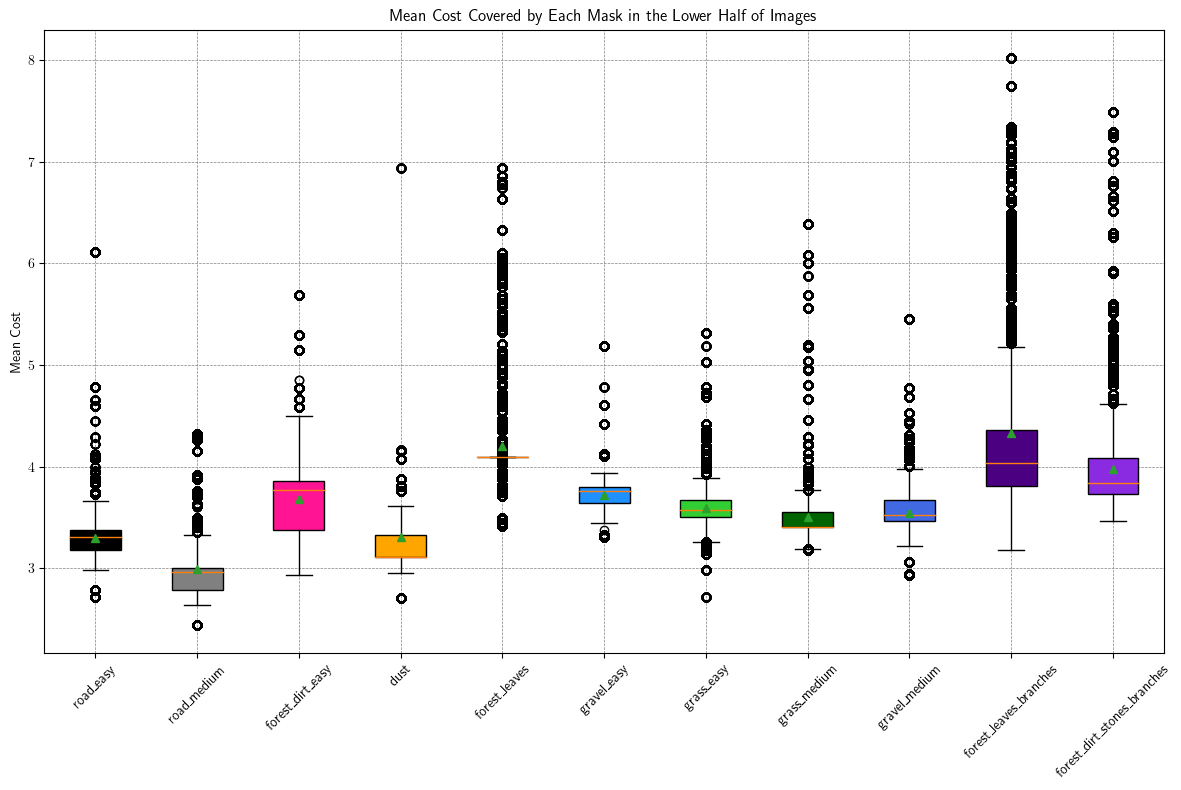

In [153]:
# New color scheme mapped to class names
colors = {
    "road_easy": "black",
    "road_medium": "grey",
    "forest_dirt_easy": "deeppink",
    "dust": "orange",
    "forest_leaves": "firebrick",
    "forest_dirt_medium": "navy",
    "gravel_easy": "dodgerblue",
    "grass_easy": "limegreen",
    "grass_medium": "darkgreen",
    "gravel_medium": "royalblue",
    "forest_leaves_branches": "indigo",
    "forest_dirt_stones_branches": "blueviolet",
    "sand_hard": "darkgoldenrod",
    "sand_medium": "orangered",
}

# Ensure there are enough colors defined for the number of classes
if len(plot_labels) > len(colors):
    print("Not enough colors defined for the number of classes, consider adding more colors.")
else:
    plt.figure(figsize=(12, 8))
    bp = plt.boxplot(plot_data, labels=plot_labels, patch_artist=True, showmeans=True)

    # Apply specific colors to each box based on class name
    for patch, label in zip(bp['boxes'], plot_labels):
        patch.set_facecolor(colors[label])

    plt.title('Mean Cost Covered by Each Mask in the Lower Half of Images')
    plt.ylabel('Mean Cost')
    plt.xticks(rotation=45)  # Rotate subclass names for better readability
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')  # Adjust grid for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

In [16]:
# Print table header
print(f"{'Class':<15}{'Standard Deviation':<20}{'Number of Samples':<20}")

# Calculate and print stats for each class
for subclass, costs in mean_costs.items():
    if costs:  # Ensure there are data points for the class
        std_dev = np.std(costs)  # Compute standard deviation
        num_samples = len(costs)  # Compute number of samples
        print(f"{subclass:<15}{std_dev:<20.4f}{num_samples:<20}")

Class          Standard Deviation  Number of Samples   
road_easy      0.2612              7                   
road_medium    0.3542              12                  
forest_dirt_easy0.1900              3                   
dust           0.2575              7                   
forest_leaves  0.0000              1                   
gravel_easy    0.1391              4                   
grass_easy     0.1994              9                   
grass_medium   0.1460              13                  
gravel_medium  0.0782              4                   
forest_leaves_branches0.1547              3                   
forest_dirt_stones_branches0.6787              6                   


In [11]:
plot_labels

['grass_easy',
 'grass_medium',
 'dust',
 'forest_dirt_easy',
 'forest_dirt_stones_branches',
 'forest_leaves',
 'forest_leaves_branches',
 'gravel_easy',
 'gravel_medium',
 'road_easy',
 'road_medium']

In [12]:
plot_data

[[3.567739963531494,
  3.6772613525390625,
  3.74418568611145,
  3.7496140003204346,
  3.5033228397369385,
  3.6671199798583984,
  3.690031051635742,
  3.485804796218872,
  4.19954252243042],
 [3.7860703468322754,
  3.894608497619629,
  3.4892592430114746,
  3.4838290214538574,
  3.4066221714019775,
  3.511462450027466,
  3.451401948928833,
  3.4062106609344482,
  3.516695022583008,
  3.662339448928833,
  3.4421141147613525,
  3.4148781299591064,
  3.547630548477173],
 [3.116414785385132,
  3.8094255924224854,
  3.3314523696899414,
  3.0197765827178955],
 [3.787280797958374, 3.4234249591827393, 3.856593370437622],
 [4.177234649658203,
  5.590794086456299,
  5.14516019821167,
  3.7690796852111816,
  4.854973793029785,
  3.8530056476593018],
 [4.206851482391357],
 [4.185030460357666, 4.542906761169434, 4.256101608276367],
 [3.7032651901245117,
  3.8982181549072266,
  3.749706983566284,
  3.5087571144104004],
 [3.5308620929718018,
  3.678075075149536,
  3.5165624618530273,
  3.46880483627

In [13]:
mean_costs

{'grass_easy': [3.567739963531494,
  3.6772613525390625,
  3.74418568611145,
  3.7496140003204346,
  3.5033228397369385,
  3.6671199798583984,
  3.690031051635742,
  3.485804796218872,
  4.19954252243042],
 'grass_medium': [3.7860703468322754,
  3.894608497619629,
  3.4892592430114746,
  3.4838290214538574,
  3.4066221714019775,
  3.511462450027466,
  3.451401948928833,
  3.4062106609344482,
  3.516695022583008,
  3.662339448928833,
  3.4421141147613525,
  3.4148781299591064,
  3.547630548477173],
 'dust': [3.116414785385132,
  3.8094255924224854,
  3.3314523696899414,
  3.0197765827178955],
 'forest_dirt_easy': [3.787280797958374,
  3.4234249591827393,
  3.856593370437622],
 'forest_dirt_medium': [],
 'forest_dirt_stones_branches': [4.177234649658203,
  5.590794086456299,
  5.14516019821167,
  3.7690796852111816,
  4.854973793029785,
  3.8530056476593018],
 'forest_leaves': [4.206851482391357],
 'forest_leaves_branches': [4.185030460357666,
  4.542906761169434,
  4.256101608276367],
 

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [91]:
f = "00115_seg.npy"

s = np.load('/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/segmentation/'+f)
m1 = np.squeeze(np.load('/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/annotation/masks/00115_concrete.npy'))
m2 = np.squeeze(np.load('/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/annotation/masks/00115_sand.npy'))
m3 = np.squeeze(np.load('/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/annotation/masks/00115_grass.npy'))

In [92]:
m3

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [93]:
grid_cosmap = downsample_to_grid(s)

In [94]:
masked_s = s*m2

In [95]:
grid_m1 = downsample_to_grid(m1)
grid_m2 = downsample_to_grid(m2)
grid_m3 = downsample_to_grid(m3)

In [96]:
masked_s

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 3.80695, 3.80695, 3.80695],
       [0.     , 0.     , 0.     , ..., 3.80695, 3.80695, 3.80695],
       [0.     , 0.     , 0.     , ..., 3.80695, 3.80695, 3.80695]],
      dtype=float32)

In [97]:
grid_masked_s = downsample_to_grid(masked_s)

In [98]:
grid_masked_s

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3

In [99]:
grid_cosmap

array([[2.96114039, 2.96114039, 2.96114039, 2.96114039, 2.96114039,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009],
       [2.96114039, 2.96114039, 2.96114039, 2.96114039, 2.96114039,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009],
       [2.96114039, 2.96114039, 2.96114039, 2.96114039, 2.96114039,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3.80695009, 3.80695009],
       [2.96114039, 2.96114039, 2.96114039, 2.96114039, 2.96114039,
        3.87979174, 3.80695009, 3.80695009, 3.80695009, 3.80695009,
        3.80695009, 3.80695009, 3.80695009, 3

In [100]:
norm = mcolors.Normalize(vmin=0, vmax=10)

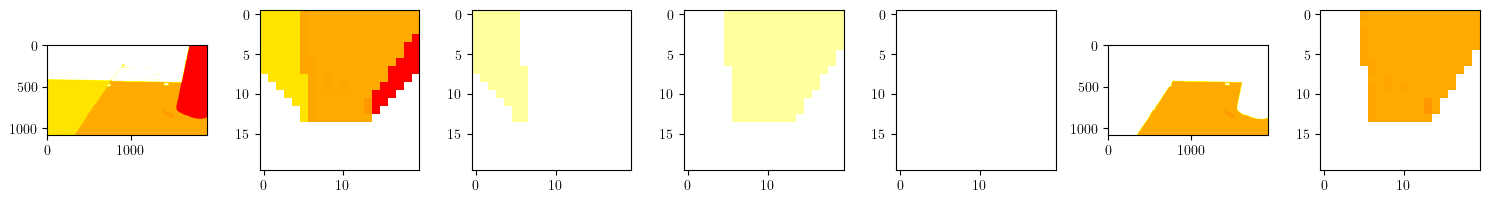

In [101]:


# Assuming img, sam_colored_costmap_with_grid, and costmap are already defined
_, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(15, 15))

# Plot the SAM colored costmap with grid
ax1.imshow(s, cmap="hot_r", norm=norm)

# Plot the costmap with "hot_r" colormap and specific vmin and vmax
ax2.imshow(grid_cosmap, cmap="hot_r", norm=norm)

# Plot the costmap with "hot_r" colormap and specific vmin and vmax
ax3.imshow(grid_m1, cmap="hot_r", norm=norm)

# Plot the costmap with "hot_r" colormap and specific vmin and vmax
ax4.imshow(grid_m2, cmap="hot_r", norm=norm)

# Plot the costmap with "hot_r" colormap and specific vmin and vmax
ax5.imshow(grid_m3, cmap="hot_r", norm=norm)

# Plot the costmap with "hot_r" colormap and specific vmin and vmax
ax6.imshow(masked_s, cmap="hot_r", norm=norm)

# Plot the costmap with "hot_r" colormap and specific vmin and vmax
ax7.imshow(grid_masked_s, cmap="hot_r", norm=norm)

# Adjust layout
plt.tight_layout()
plt.show()

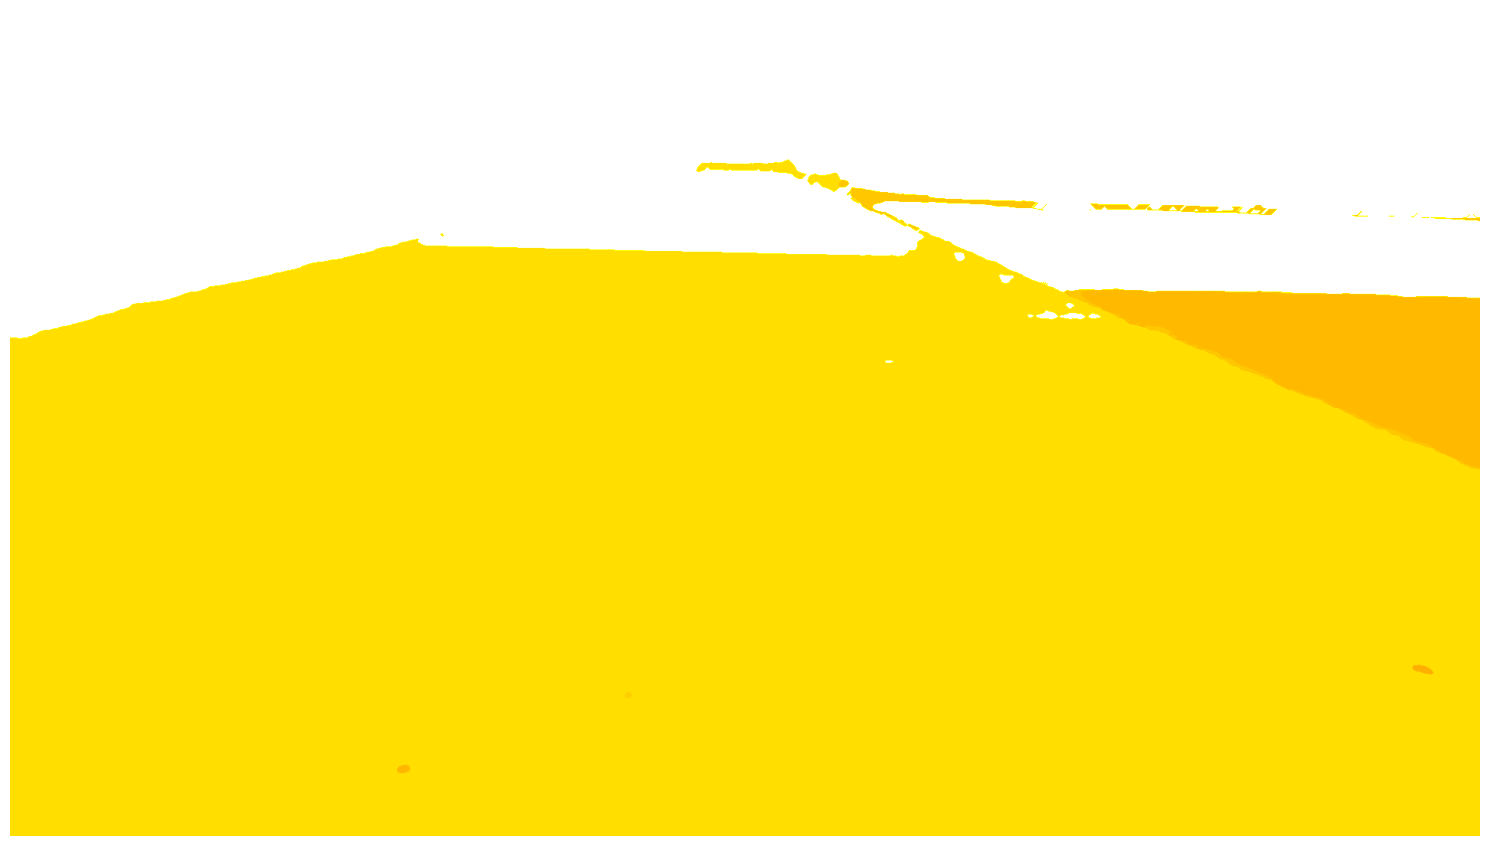

In [14]:
# Assuming img, sam_colored_costmap_with_grid, and costmap are already defined
_, (ax1) = plt.subplots(1, 1, figsize=(15, 15))

# Plot the SAM colored costmap with grid
ax1.imshow(s, cmap="hot_r", norm=norm)
ax1.axis('off')
# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
segmentation_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/segmentation/'
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/visualization/with_sam/'

if not os.path.exists(results_base_dir):
    os.makedirs(results_base_dir)

for file_name in tqdm(os.listdir(segmentation_dir)):
    if file_name.endswith('.npy'):
        # Load the segmentation file
        file_path = os.path.join(segmentation_dir, file_name)
        segmentation = np.load(file_path)
        image_id = file_name.split('_')[0]
        
        # Raw segmentation visualization
        result_image_path = os.path.join(results_base_dir, f"{image_id}_seg_raw.png")
        plt.figure(figsize=(8, 6))
        plt.imshow(segmentation, cmap="hot_r", vmin=0, vmax=10)
        plt.axis('off')
        plt.savefig(result_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        # Grid-downsampled segmentation visualization
        result_image_grid_path = os.path.join(results_base_dir, f"{image_id}_seg_grid.png")
        grid_cosmap = downsample_to_grid(segmentation)
        plt.figure(figsize=(8, 6))
        plt.imshow(grid_cosmap, cmap="hot_r", vmin=0, vmax=10)
        plt.axis('off')
        plt.savefig(result_image_grid_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
print("Processing completed.")

100%|██████████| 75/75 [00:12<00:00,  6.08it/s]

Processing completed.


GRID SAM

In [ ]:
f = "06551_seg.npy"

g = np.load('/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/segmentation/'+f)

In [15]:
s.shape

(1080, 1920)

In [16]:
im = upsample_grid_to_image(grid_cosmap,s.shape)

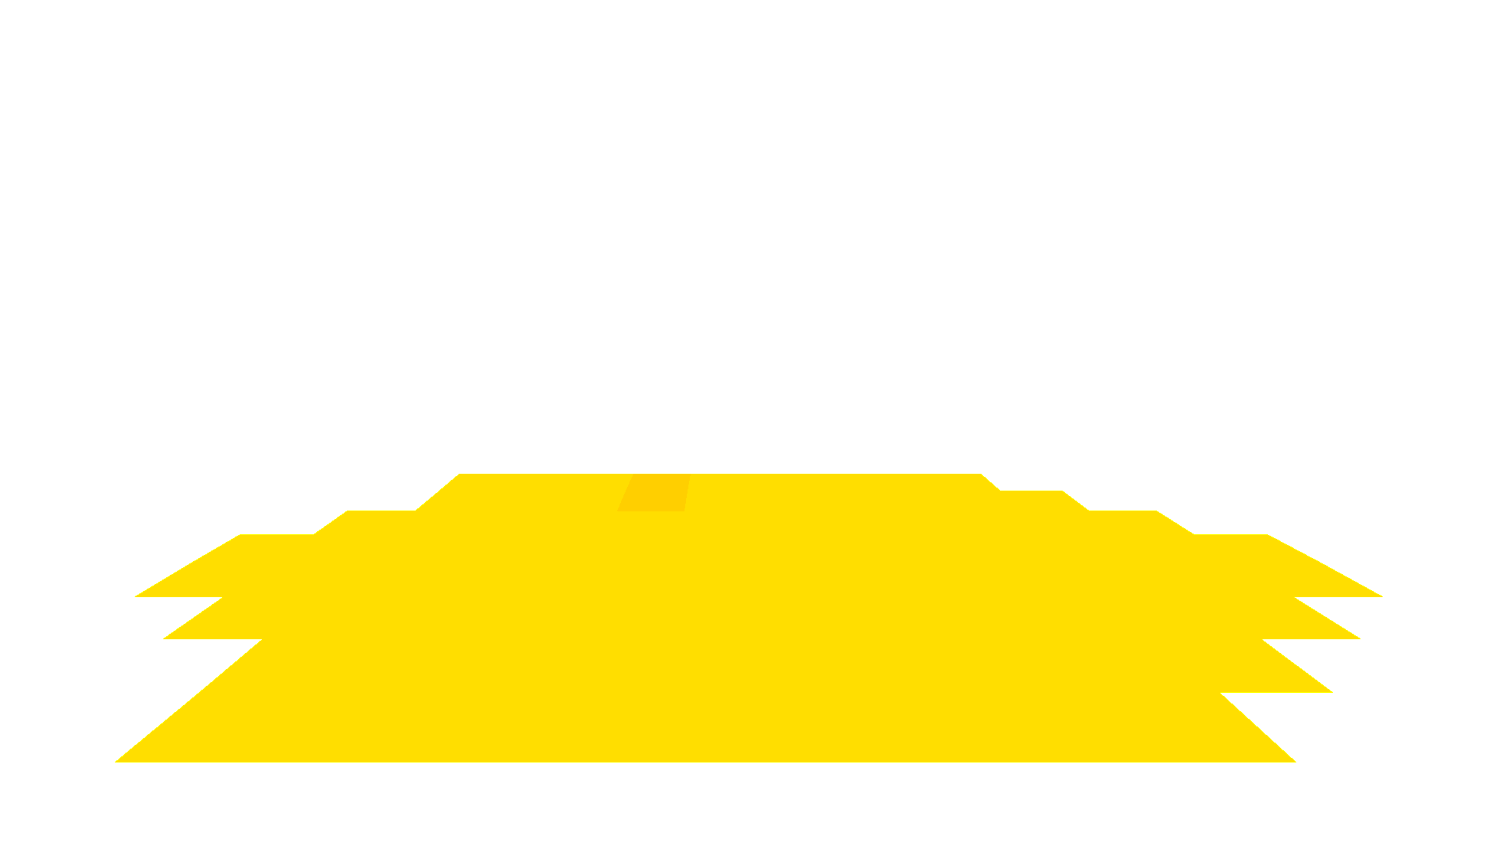

In [17]:
# Assuming img, sam_colored_costmap_with_grid, and costmap are already defined
_, (ax1) = plt.subplots(1, 1, figsize=(15, 15))

# Plot the SAM colored costmap with grid
ax1.imshow(im, cmap="hot_r", norm=norm)
ax1.axis('off')
# Adjust layout
plt.tight_layout()
plt.show()

In [85]:
def compute_mean_cost_and_log_grid(sub_folder, source_base_dir, masks_dir, results_base_dir):
    cost_maps_dir = os.path.join(source_base_dir, sub_folder)
    mask_info_dir = os.path.join(masks_dir, sub_folder)
    results_dir = os.path.join(results_base_dir, sub_folder)
    
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)
    
    for cost_map_file in tqdm(os.listdir(cost_maps_dir), desc="Processing Cost Maps"):
        if not cost_map_file.endswith('.npy'):
            continue  # Skip non-numpy files
        
        cost_map_path = os.path.join(cost_maps_dir, cost_map_file)
        cost_map = np.load(cost_map_path)
        
        # Load the corresponding mask JSON file
        json_filename = cost_map_file.replace('_seg.npy', '_masks.json')
        json_path = os.path.join(mask_info_dir, json_filename)
        
        if not os.path.exists(json_path):
            print(f"No mask JSON for {cost_map_file}")
            continue
        
        with open(json_path, 'r') as f:
            masks_info = json.load(f)
        
        log_data = {}
        for class_id, info in masks_info.items():
            if info['name'] in subclass_list:
                mask_path = info['mask_path']
                # load the mask
                mask =  np.squeeze(np.load(mask_path))
                masked_cost_map = cost_map*mask
                grided_masked_cost_map = downsample_to_grid(masked_cost_map)
                
                if grided_masked_cost_map.size > 0:
                    mean_cost = grided_masked_cost_map.mean().item()  # Ensure it's a Python float
                    log_data[info['name']] = log_data.get(info['name'], []) + [mean_cost]
        
        # Save the log data for each image
        log_filename = cost_map_file.replace('_seg.npy', '_mean_cost.json')
        log_path = os.path.join(results_dir, log_filename)
        with open(log_path, 'w') as f:
            json.dump(log_data, f, indent=4)

# Example usage




In [258]:
def compute_mean_cost_and_log_2(sub_folder, source_base_dir, masks_dir, results_base_dir):
    cost_maps_dir = os.path.join(source_base_dir, sub_folder)
    mask_info_dir = os.path.join(masks_dir, sub_folder)
    results_dir = os.path.join(results_base_dir, sub_folder)
    
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)
    
    for cost_map_file in tqdm(os.listdir(cost_maps_dir), desc="Processing Cost Maps"):
        if not cost_map_file.endswith('.npy'):
            continue  # Skip non-numpy files
        
        cost_map_path = os.path.join(cost_maps_dir, cost_map_file)
        cost_map = np.load(cost_map_path)
        
        # Load the corresponding mask JSON file
        json_filename = cost_map_file.replace('_seg.npy', '_masks.json')
        json_path = os.path.join(mask_info_dir, json_filename)
        
        if not os.path.exists(json_path):
            print(f"No mask JSON for {cost_map_file}")
            continue
        
        with open(json_path, 'r') as f:
            masks_info = json.load(f)
        
        log_data = {}
        for class_id, info in masks_info.items():
            if info['name'] in subclass_list:
                mask_path = info['mask_path']
                # load the mask
                mask =  np.squeeze(np.load(mask_path))
                masked_cost_map = cost_map*mask
                grided_masked_cost_map = downsample_to_grid(masked_cost_map)
                grided_masked_cost_map = np.concatenate(grided_masked_cost_map)
                grided_masked_cost_map = grided_masked_cost_map[grided_masked_cost_map != 0.0]
                
                if grided_masked_cost_map.size > 0:
                    mean_cost = grided_masked_cost_map.tolist()
                    log_data[info['name']] = log_data.get(info['name'], []) + [mean_cost]
        
        # Save the log data for each image
        log_filename = cost_map_file.replace('_seg.npy', '_mean_cost.json')
        log_path = os.path.join(results_dir, log_filename)
        with open(log_path, 'w') as f:
            json.dump(log_data, f, indent=4)

In [259]:
source_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/segmentation'
masks_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/annotation'
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/mean_cost_by_class_grid'
compute_mean_cost_and_log_2("", source_base_dir, masks_dir, results_base_dir)

Processing Cost Maps: 100%|██████████| 75/75 [00:11<00:00,  6.54it/s]


In [333]:
import glob
sub_folder=""
# Path to the directory containing the JSON files
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/mean_cost_by_class_grid'
results_dir = os.path.join(results_base_dir, sub_folder)

# Initialize a dictionary to aggregate data
mean_costs = {subclass: [] for subclass in subclass_list}

# List all JSON files in the directory
json_files = glob.glob(os.path.join(results_dir, "*.json"))

# Loop over each file and aggregate data
for file_path in tqdm(json_files):
    with open(file_path, 'r') as file:
        data = json.load(file)
        for subclass in subclass_list:
            if subclass in data:
                mean_costs[subclass].extend(data[subclass])


data = {}
for k in tqdm(mean_costs.keys()):
    if len(mean_costs[k]) > 0:
        m = np.mean(np.concatenate(mean_costs[k]))
        s = np.std(np.concatenate(mean_costs[k]))
        data[k] = {"mean": m, "std": s}

# Filter out empty lists to avoid errors in plotting
plot_data_1 = [np.concatenate(mean_costs[subclass]) for subclass in subclass_list if mean_costs[subclass]]
plot_labels = [subclass for subclass in subclass_list if mean_costs[subclass]]

100%|██████████| 11/11 [00:00<00:00, 4465.05it/s]


In [229]:
data

{'road_easy': {'mean': 3.362034348408265, 'std': 0.35232944918359654},
 'road_medium': {'mean': 3.0584558542435603, 'std': 0.33179723321034676},
 'forest_dirt_easy': {'mean': 3.7609177325582746, 'std': 0.3179518953399807},
 'dust': {'mean': 3.394839901123604, 'std': 0.3714875997384739},
 'forest_leaves': {'mean': 4.2914623495923925, 'std': 0.5141902221465683},
 'gravel_easy': {'mean': 3.7560295142874813, 'std': 0.21655056073989462},
 'grass_easy': {'mean': 3.6517091143014766, 'std': 0.22899562013667818},
 'grass_medium': {'mean': 3.523219053676639, 'std': 0.24819055121733571},
 'gravel_medium': {'mean': 3.5743731035847044, 'std': 0.18102352741334568},
 'forest_leaves_branches': {'mean': 4.633160165164261,
  'std': 0.9201850464119334},
 'forest_dirt_stones_branches': {'mean': 4.1440728781920555,
  'std': 0.665414362275919}}

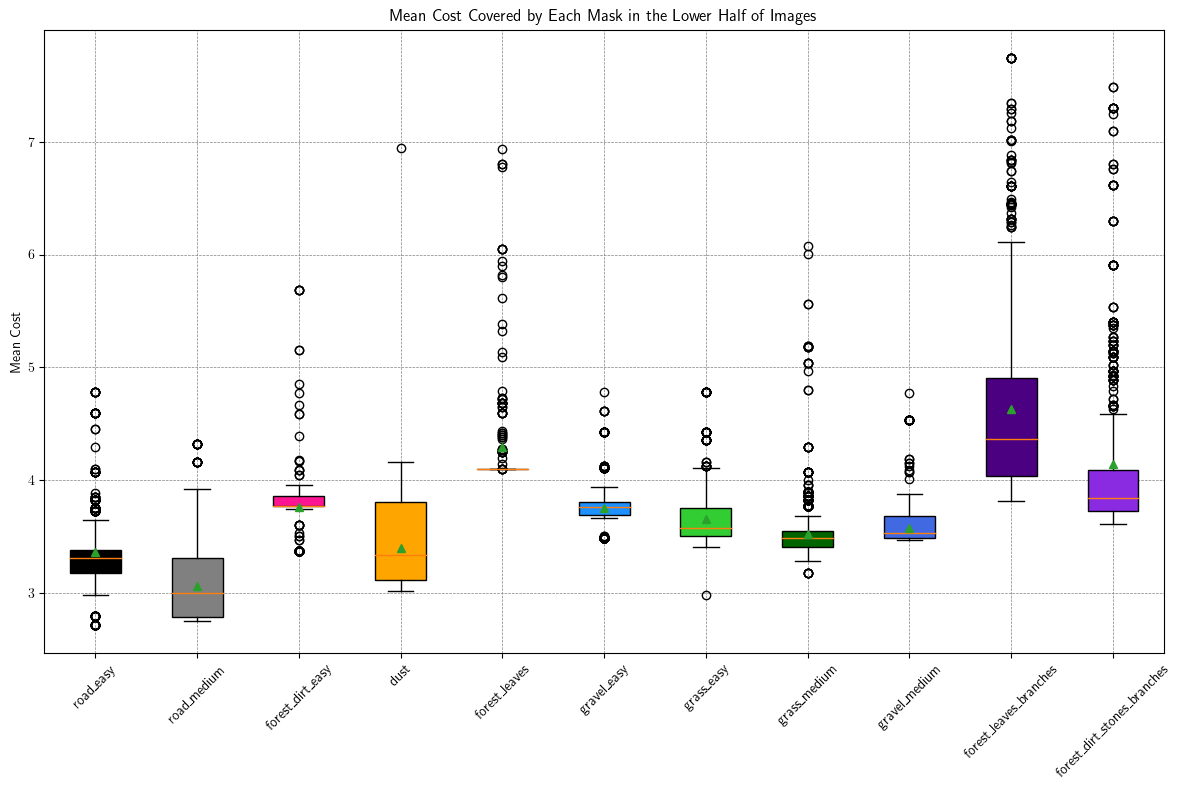

In [262]:
# New color scheme mapped to class names
colors = {
    "road_easy": "black",
    "road_medium": "grey",
    "forest_dirt_easy": "deeppink",
    "dust": "orange",
    "forest_leaves": "firebrick",
    "forest_dirt_medium": "navy",
    "gravel_easy": "dodgerblue",
    "grass_easy": "limegreen",
    "grass_medium": "darkgreen",
    "gravel_medium": "royalblue",
    "forest_leaves_branches": "indigo",
    "forest_dirt_stones_branches": "blueviolet",
    "sand_hard": "darkgoldenrod",
    "sand_medium": "orangered",
}

# Ensure there are enough colors defined for the number of classes
if len(plot_labels) > len(colors):
    print("Not enough colors defined for the number of classes, consider adding more colors.")
else:
    plt.figure(figsize=(12, 8))
    bp = plt.boxplot(plot_data_1, labels=plot_labels, patch_artist=True, showmeans=True)

    # Apply specific colors to each box based on class name
    for patch, label in zip(bp['boxes'], plot_labels):
        patch.set_facecolor(colors[label])

    plt.title('Mean Cost Covered by Each Mask in the Lower Half of Images')
    plt.ylabel('Mean Cost')
    plt.xticks(rotation=45)  # Rotate subclass names for better readability
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')  # Adjust grid for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

In [237]:
# Print table header
print(f"{'Class':<15}{'Standard Deviation':<20}{'Number of Samples':<20}")

# Calculate and print stats for each class
for subclass, costs in mean_costs.items():
    if costs and costs != 0:  # Ensure there are data points for the class
        std_dev = np.std(np.concatenate(costs))  # Compute standard deviation
        num_samples = len(costs)  # Compute number of samples
        print(f"{subclass:<15}{std_dev:<20.4f}{num_samples:<20}")

Class          Standard Deviation  Number of Samples   
road_easy      0.3523              7                   
road_medium    0.3318              11                  
forest_dirt_easy0.3180              3                   
dust           0.3715              4                   
forest_leaves  0.5142              1                   
gravel_easy    0.2166              4                   
grass_easy     0.2290              8                   
grass_medium   0.2482              13                  
gravel_medium  0.1810              4                   
forest_leaves_branches0.9202              3                   
forest_dirt_stones_branches0.6654              6                   


In [263]:
def compute_mean_cost_and_log_grid_gab(sub_folder, source_base_dir, masks_dir, results_base_dir):
    cost_maps_dir = os.path.join(source_base_dir, sub_folder)
    mask_info_dir = os.path.join(masks_dir, sub_folder)
    results_dir = os.path.join(results_base_dir, sub_folder)
    
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)
    
    for cost_map_file in tqdm(os.listdir(cost_maps_dir), desc="Processing Cost Maps"):
        if not cost_map_file.endswith('.npy'):
            continue  # Skip non-numpy files
        
        cost_map_path = os.path.join(cost_maps_dir, cost_map_file)
        cost_map = np.load(cost_map_path)
        
        # Load the corresponding mask JSON file
        json_filename = cost_map_file.replace('_gab_seg.npy', '_masks.json')
        json_path = os.path.join(mask_info_dir, json_filename)
        
        if not os.path.exists(json_path):
            print(f"No mask JSON for {cost_map_file}")
            continue
        
        with open(json_path, 'r') as f:
            masks_info = json.load(f)
        
        log_data = {}
        for class_id, info in masks_info.items():
            if info['name'] in subclass_list:
                mask_path = info['mask_path']
                # load the mask
                mask =  np.squeeze(np.load(mask_path))
                grided_masked = downsample_to_grid(mask)

                grided_masked_cost_map = cost_map*grided_masked
                
                if grided_masked_cost_map.size > 0:
                    mean_cost = grided_masked_cost_map.mean().item()  # Ensure it's a Python float
                    log_data[info['name']] = log_data.get(info['name'], []) + [mean_cost]
        
        # Save the log data for each image
        log_filename = cost_map_file.replace('_seg.npy', '_mean_cost.json')
        log_path = os.path.join(results_dir, log_filename)
        with open(log_path, 'w') as f:
            json.dump(log_data, f, indent=4)

# Example usage

In [240]:
def compute_mean_cost_and_log_grid_gab_2(sub_folder, source_base_dir, masks_dir, results_base_dir):
    cost_maps_dir = os.path.join(source_base_dir, sub_folder)
    mask_info_dir = os.path.join(masks_dir, sub_folder)
    results_dir = os.path.join(results_base_dir, sub_folder)
    
    # Ensure the results directory exists
    os.makedirs(results_dir, exist_ok=True)
    
    for cost_map_file in tqdm(os.listdir(cost_maps_dir), desc="Processing Cost Maps"):
        if not cost_map_file.endswith('.npy'):
            continue  # Skip non-numpy files
        
        cost_map_path = os.path.join(cost_maps_dir, cost_map_file)
        cost_map = np.load(cost_map_path)
        
        # Load the corresponding mask JSON file
        json_filename = cost_map_file.replace('_gab_seg.npy', '_masks.json')
        json_path = os.path.join(mask_info_dir, json_filename)
        
        if not os.path.exists(json_path):
            print(f"No mask JSON for {cost_map_file}")
            continue
        
        with open(json_path, 'r') as f:
            masks_info = json.load(f)
        
        log_data = {}
        for class_id, info in masks_info.items():
            if info['name'] in subclass_list:
                mask_path = info['mask_path']
                # load the mask
                mask =  np.squeeze(np.load(mask_path))
                grided_masked = downsample_to_grid(mask)

                grided_masked_cost_map = cost_map*grided_masked
                grided_masked_cost_map = np.concatenate(grided_masked_cost_map)
                grided_masked_cost_map = grided_masked_cost_map[grided_masked_cost_map != 0.0]
                
                if grided_masked_cost_map.size > 0:
                    mean_cost = grided_masked_cost_map.tolist()
                    log_data[info['name']] = log_data.get(info['name'], []) + [mean_cost]
        
        # Save the log data for each image
        log_filename = cost_map_file.replace('_seg.npy', '_mean_cost.json')
        log_path = os.path.join(results_dir, log_filename)
        with open(log_path, 'w') as f:
            json.dump(log_data, f, indent=4)

In [264]:
source_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/gab_seg'
masks_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/annotation'
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/mean_cost_by_class_gab_grid'
compute_mean_cost_and_log_grid_gab_2("", source_base_dir, masks_dir, results_base_dir)

Processing Cost Maps: 100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


In [334]:
import glob
sub_folder=""
# Path to the directory containing the JSON files
results_base_dir = '/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results/mean_cost_by_class_gab_grid'
results_dir = os.path.join(results_base_dir, sub_folder)

exclude_ids = ["00639", "01163", "06046"]

# Initialize a dictionary to aggregate data
mean_costs = {subclass: [] for subclass in subclass_list}

# List all JSON files in the directory
json_files = glob.glob(os.path.join(results_dir, "*.json"))

# Loop over each file and aggregate data
for file_path in tqdm(json_files):
    if any(exclude_id in os.path.basename(file_path) for exclude_id in exclude_ids):
        continue

    with open(file_path, 'r') as file:
        data = json.load(file)
        for subclass in subclass_list:
            if subclass in data:
                mean_costs[subclass].extend(data[subclass])


data = {}
for k in tqdm(mean_costs.keys()):
    if len(mean_costs[k]) > 0:
        m = np.mean(np.concatenate(mean_costs[k]))
        s = np.std(np.concatenate(mean_costs[k]))
        data[k] = {"mean": m, "std": s}

# Filter out empty lists to avoid errors in plotting
plot_data_2 = [np.concatenate(mean_costs[subclass]) for subclass in subclass_list if mean_costs[subclass]]
plot_labels = [subclass for subclass in subclass_list if mean_costs[subclass]]

100%|██████████| 11/11 [00:00<00:00, 6089.93it/s]


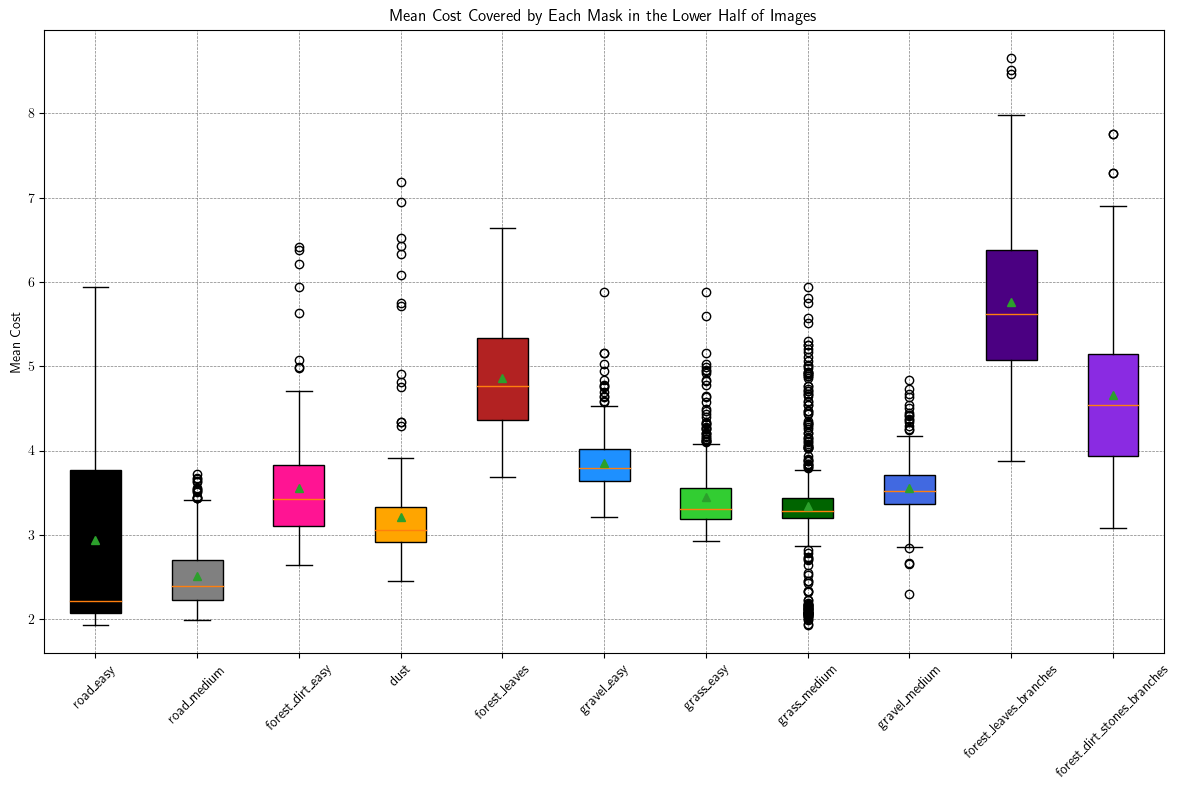

In [266]:
# New color scheme mapped to class names
colors = {
    "road_easy": "black",
    "road_medium": "grey",
    "forest_dirt_easy": "deeppink",
    "dust": "orange",
    "forest_leaves": "firebrick",
    "forest_dirt_medium": "navy",
    "gravel_easy": "dodgerblue",
    "grass_easy": "limegreen",
    "grass_medium": "darkgreen",
    "gravel_medium": "royalblue",
    "forest_leaves_branches": "indigo",
    "forest_dirt_stones_branches": "blueviolet",
    "sand_hard": "darkgoldenrod",
    "sand_medium": "orangered",
}

# Ensure there are enough colors defined for the number of classes
if len(plot_labels) > len(colors):
    print("Not enough colors defined for the number of classes, consider adding more colors.")
else:
    plt.figure(figsize=(12, 8))
    bp = plt.boxplot(plot_data_2, labels=plot_labels, patch_artist=True, showmeans=True)

    # Apply specific colors to each box based on class name
    for patch, label in zip(bp['boxes'], plot_labels):
        patch.set_facecolor(colors[label])

    plt.title('Mean Cost Covered by Each Mask in the Lower Half of Images')
    plt.ylabel('Mean Cost')
    plt.xticks(rotation=45)  # Rotate subclass names for better readability
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')  # Adjust grid for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

In [250]:
# Print table header
print(f"{'Class':<15}{'Standard Deviation':<20}{'Number of Samples':<20}")

# Calculate and print stats for each class
for subclass, costs in mean_costs.items():
    if costs and costs != 0:  # Ensure there are data points for the class
        std_dev = np.std(np.concatenate(costs))  # Compute standard deviation
        num_samples = len(costs)  # Compute number of samples
        print(f"{subclass:<15}{std_dev:<20.4f}{num_samples:<20}")

Class          Standard Deviation  Number of Samples   
road_easy      1.1468              6                   
road_medium    0.3734              9                   
forest_dirt_easy0.6481              3                   
dust           0.6255              4                   
forest_leaves  0.6755              1                   
gravel_easy    0.3489              4                   
grass_easy     0.4119              8                   
grass_medium   0.5998              13                  
gravel_medium  0.3236              4                   
forest_leaves_branches0.9378              3                   
forest_dirt_stones_branches0.9084              6                   


In [251]:
Class          Standard Deviation  Number of Samples   
road_easy      0.3523              7                   
road_medium    0.3318              11                  
forest_dirt_easy0.3180              3                   
dust           0.3715              4                   
forest_leaves  0.5142              1                   
gravel_easy    0.2166              4                   
grass_easy     0.2290              8                   
grass_medium   0.2482              13                  
gravel_medium  0.1810              4                   
forest_leaves_branches0.9202              3                   
forest_dirt_stones_branches0.6654              6 



Class          Standard Deviation  Number of Samples   
road_easy      1.1468              6                   
road_medium    0.3734              9                   
forest_dirt_easy0.6481              3                   
dust           0.6255              4                   
forest_leaves  0.6755              1                   
gravel_easy    0.3489              4                   
grass_easy     0.4119              8                   
grass_medium   0.5998              13                  
gravel_medium  0.3236              4                   
forest_leaves_branches0.9378              3                   
forest_dirt_stones_branches0.9084              6

SyntaxError: invalid syntax (2685336051.py, line 1)

In [268]:
len(plot_data_1)

11

In [270]:
len(plot_data_2)

11

ValueError: List of boxplot statistics and `positions` values must have same the length

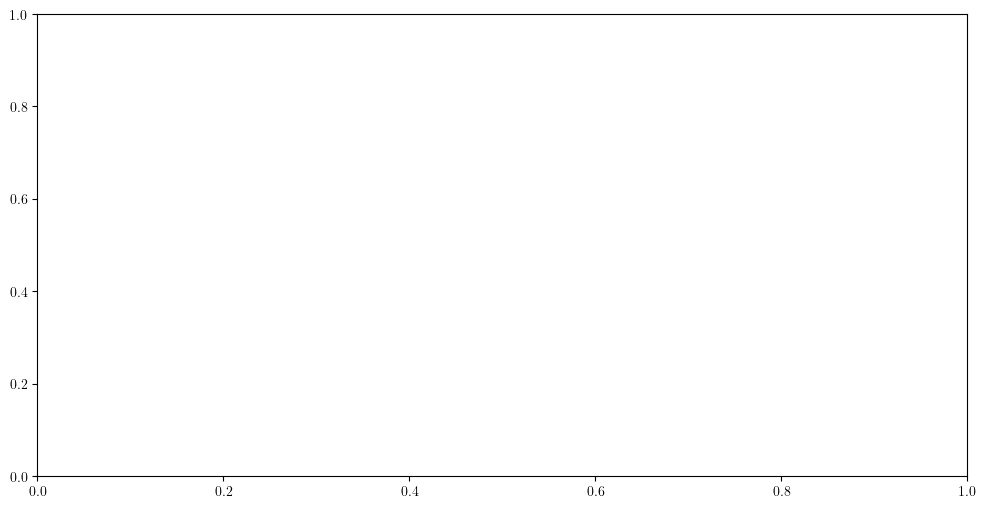

In [267]:
import numpy as np
import matplotlib.pyplot as plt


# New color scheme mapped to class names
colors = {
    "road_easy": "black",
    "road_medium": "grey",
    "forest_dirt_easy": "deeppink",
    "dust": "orange",
    "forest_leaves": "firebrick",
    "forest_dirt_medium": "navy",
    "gravel_easy": "dodgerblue",
    "grass_easy": "limegreen",
    "grass_medium": "darkgreen",
    "gravel_medium": "royalblue",
    "forest_leaves_branches": "indigo",
    "forest_dirt_stones_branches": "blueviolet",
    "sand_hard": "darkgoldenrod",
    "sand_medium": "orangered",
}

# Ensure there are enough colors defined for the number of classes
if len(plot_labels) > len(colors):
    print("Not enough colors defined for the number of classes, consider adding more colors.")
else:
    fig, ax = plt.subplots(figsize=(12, 6))

    for idx, (plot_data_1_series, plot_data_2_series) in enumerate(zip(plot_data_1, plot_data_2)):
        positions = np.arange(len(plot_data_1_series)) + 1 + 0.1 * (idx - 1)
        bp = ax.boxplot(plot_data_1_series, positions=positions, widths=0.2, patch_artist=True, showmeans=True)

        # Apply specific colors to each box based on class name
        for patch, label in zip(bp['boxes'], plot_labels):
            color = colors[label]
            patch.set_facecolor(color)

        # Boxplot for the second series with adjusted transparency
        bp = ax.boxplot(plot_data_2_series, positions=positions, widths=0.2, patch_artist=True, showmeans=True)

        # Apply specific colors to each box based on class name with adjusted transparency
        for patch, label in zip(bp['boxes'], plot_labels):
            color = colors[label] + '33'  # Adding '33' to the end for approximately 20% transparency in hexadecimal format
            patch.set_facecolor(color)

    ax.set_title('Mean Cost Covered by Each Mask in the Lower Half of Images')
    ax.set_ylabel('Mean Cost')
    ax.set_xticks(np.arange(len(plot_data_1_series)) + 1)
    ax.set_xticklabels(plot_labels, rotation=45)  # Rotate subclass names for better readability
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')  # Adjust grid for better visibility

    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()



In [343]:
plot_labels

['road_easy',
 'road_medium',
 'forest_dirt_easy',
 'dust',
 'gravel_easy',
 'grass_easy',
 'grass_medium',
 'gravel_medium',
 'forest_leaves_branches',
 'forest_dirt_stones_branches']

In [356]:
plot_labels = ['road_easy',
 'road_medium',
 'forest_dirt_easy',
 'dust',
 'gravel_easy',
 'grass_easy',
 'grass_medium',
 'gravel_medium',
 'forest_leaves_branches',
 'forest_dirt_stones_branches']

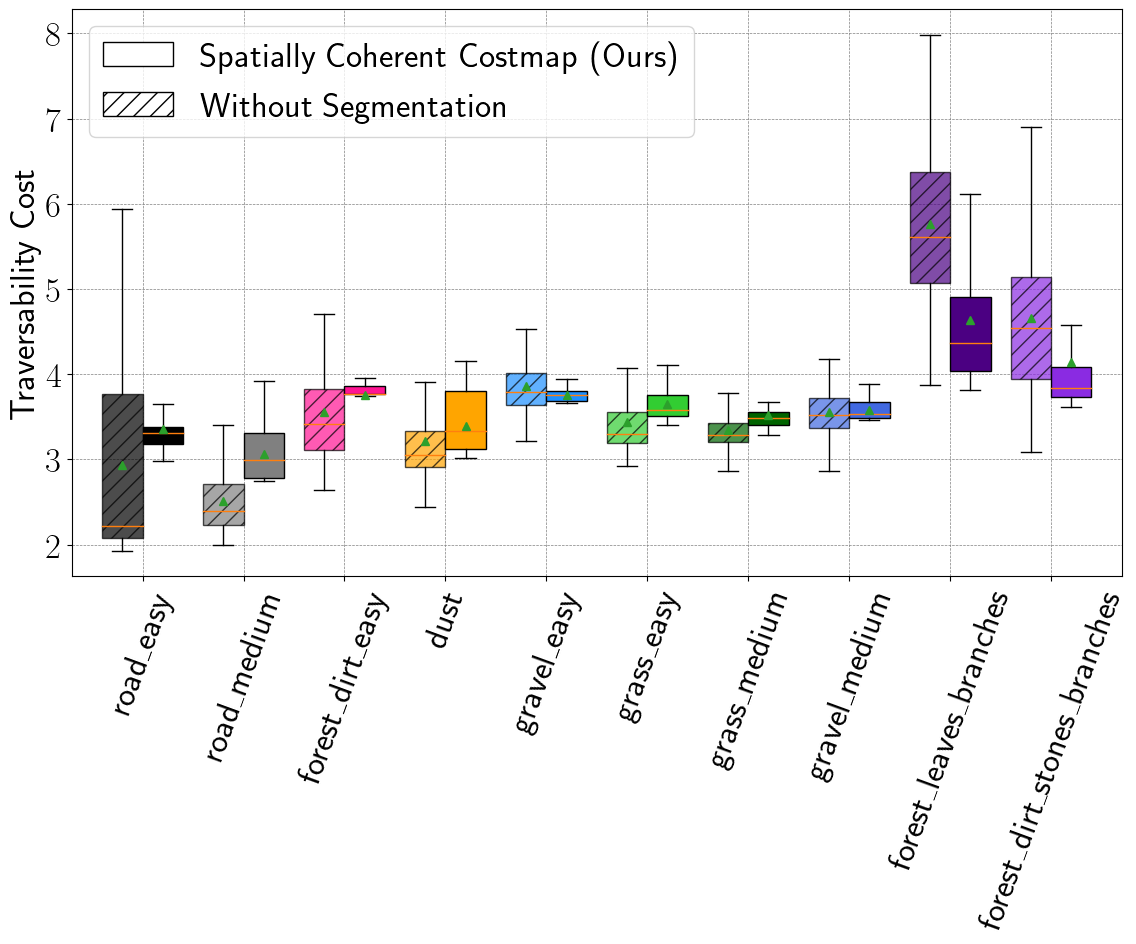

In [357]:
import matplotlib.patches as mpatches
import matplotlib
matplotlib.rcParams.update({'font.size': 25})

# New color scheme mapped to class names
colors = {
    "road_easy": "black",
    "road_medium": "grey",
    "forest_dirt_easy": "deeppink",
    "dust": "orange",
    "forest_leaves": "firebrick",
    "forest_dirt_medium": "navy",
    "gravel_easy": "dodgerblue",
    "grass_easy": "limegreen",
    "grass_medium": "darkgreen",
    "gravel_medium": "royalblue",
    "forest_leaves_branches": "indigo",
    "forest_dirt_stones_branches": "blueviolet",
    "sand_hard": "darkgoldenrod",
    "sand_medium": "orangered",
}

s = 10

# Ensure there are enough colors defined for the number of classes
if len(plot_labels) > len(colors):
    print("Not enough colors defined for the number of classes, consider adding more colors.")
else:
    plt.figure(figsize=(12, 10))
    bp1 = plt.boxplot(plot_data_2, positions=np.arange(s)-0.20, widths=0.4, patch_artist=True, showmeans=True, showfliers=False)
    bp2 = plt.boxplot(plot_data_1, positions=np.arange(s)+0.20, widths=0.4, patch_artist=True, showmeans=True, showfliers=False)

    # Apply specific colors to each box based on class name
    for patch, label in zip(bp2['boxes'], plot_labels):
        patch.set_facecolor(colors[label])

    for patch, label in zip(bp1['boxes'], plot_labels):
        patch.set_facecolor(colors[label])
        patch.set_alpha(0.7)
        patch.set_hatch("//")

    # Create custom legend patches
    legend_patches = [mpatches.Patch(label="Spatially Coherent Costmap (Ours)", edgecolor="black", facecolor="white"), mpatches.Patch(label="Without Segmentation", hatch="//", edgecolor="black", facecolor="white")]

    # Add legend
    plt.legend(handles=legend_patches)
        

    plt.ylabel('Traversability Cost')
    plt.xticks(np.arange(s), plot_labels, rotation=70)  # Rotate subclass names for better readability
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')  # Adjust grid for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.savefig("/home/ubuntu/data/IROS2024_comparizon_boxplot_algos_V2.pdf")
    plt.show()
    

## Test

In [1]:
import os
import json
import re
import shutil

In [2]:
def generate_masks_json_and_rename_npy(source_folder, target_folder):
    annotation_colormap = {
        0: {"name": "void", "color": (0, 0, 0)},
        1: {"name": "dirt", "color": (108, 64, 20)},
        2: {"name": "sand", "color": (255, 229, 204)},
        3: {"name": "grass", "color": (0, 102, 0)},
        4: {"name": "tree", "color": (0, 255, 0)},
        5: {"name": "pole", "color": (0, 153, 153)},
        6: {"name": "water", "color": (0, 128, 255)},
        7: {"name": "sky", "color": (0, 0, 255)},
        8: {"name": "vehicle", "color": (255, 255, 0)},
        9: {"name": "container_generic-object", "color": (255, 0, 127)},
        10: {"name": "asphalt", "color": (64, 64, 64)},
        11: {"name": "gravel", "color": (255, 128, 0)},
        12: {"name": "building", "color": (255, 0, 0)},
        13: {"name": "mulch", "color": (153, 76, 0)},
        14: {"name": "rock-bed", "color": (102, 102, 0)},
        15: {"name": "log", "color": (102, 0, 0)},
        16: {"name": "bicycle", "color": (0, 255, 128)},
        17: {"name": "person", "color": (204, 153, 255)},
        18: {"name": "fence", "color": (102, 0, 204)},
        19: {"name": "bush", "color": (255, 153, 204)},
        20: {"name": "sign", "color": (0, 102, 102)},
        21: {"name": "rock", "color": (153, 204, 255)},
        22: {"name": "bridge", "color": (102, 255, 255)},
        23: {"name": "concrete", "color": (101, 101, 11)},
        24: {"name": "picnic-table", "color": (114, 85, 47)},
    }

    # Create target directory if it doesn't exist
    masks_dir = os.path.join(target_folder, "annotation", "masks")
    os.makedirs(masks_dir, exist_ok=True)

    file_pattern = re.compile(r"(\d{5})_original\.png_([^_]+)_\d+\.npy")

    masks_info = {}  # To store information for JSON files

    for filename in os.listdir(source_folder):
        match = file_pattern.match(filename)
        if match:
            image_id, class_name = match.groups()
            new_filename = f"{image_id}_{class_name}.npy"
            new_file_path = os.path.join(masks_dir, new_filename)

            # Copy and rename npy file
            shutil.copy(os.path.join(source_folder, filename), new_file_path)

            if image_id not in masks_info:
                masks_info[image_id] = {}

            # Find the class index by name
            class_index = next((index for index, details in annotation_colormap.items() if details["name"] == class_name), None)
            if class_index is not None:
                masks_info[image_id][str(class_index)] = {
                    "name": class_name,
                    "color": annotation_colormap[class_index]["color"],
                    "mask_path": new_file_path
                }

    # Generate JSON files
    for image_id, masks in masks_info.items():
        json_filename = os.path.join(target_folder, "annotation", f"{image_id}_masks.json")
        with open(json_filename, 'w') as json_file:
            json.dump(masks, json_file, indent=4)

    print("JSON files generated and .npy files copied and renamed.")

In [5]:
# Example usage
source_folder = "/home/ubuntu/data/images_et_masks/masks"
target_folder = "/home/ubuntu/bigdata2/IROS2024_Ours_SAM_results"
generate_masks_json_and_rename_npy(source_folder, target_folder)

JSON files generated and .npy files copied and renamed.
